![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Transfer Learning Concepts

You may recall *Practicum AI*"s heroine Amelia, the AI-savvy nutritionist. At the end of our *[Deep Learning Foundations course](https://practicumai.org/courses/deep_learning/)*, Amelia was helping with a computer vision project. If only she had known about transfer learning, it could have saved her a lot of time! In this notebook, we will get some hands-on experience with transfer learning and show you how to use it to improve your workflows.

![Figure 2 of the AgriNet paper used as the cover image for this notebook. Figure 2 depicts using transfer learning to make a computer vision model more efficient](images/agrinet_figure-cover.jpg)


## AI Pathway review for Transfer Learning & AgriNet 

If you have taken our [Getting Started with AI course](https://practicumai.org/courses/getting_started/), you may remember this figure of the AI Application Development Pathway. Let's take a quick review of how we will apply this to our case study of AgriNet and it's use of transfer learning.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we will be trying to make a computer vision model that can recognize images of plants, and categorize them as "healthy", "diseased", and a few other class categories that are plant-specific. 
2. **Gather data:** The data for the example comes from [HuggingFace](https://www.huggingface.co//), a great repository of datasets, code, and models.
3. **Clean and prepare the data:** In the *Deep Learning Foundations* course, we assumed that this was done for us. One issue that we ran into was that of class imbalance. Here, the (probably very tired) researchers that created the AgriNet dataset have already balanced the classes for us!
4. **Choose a model:** In the *Deep Learning Foundations* course, we presented the model with little detail. Here, we will use a Convolutional Neural Network (CNN) as our model, trained from scratch as a baseline, and compare it to a pre-trained VGG19 model that we've fine-tuned on the AgriNet dataset. VGG19 (Visual Geometry Group, with 19 layers) is a specific computer vision model architecture, and is pictured in the Cover Image above! We're using a version of VGG19 that has been pre-trained on the ImageNet dataset, which is a large dataset of images with 1000 classes. By fine-tuning this model, we can leverage the knowledge it has learned from the ImageNet dataset and apply it to our specific problem of plant classification. Since the Domain of ImageNet is distinctly different (1000 everyday objects) from the Domain of AgriNet (healthy and diseased plants), we'd say this was a Domain Transfer. 
   * In the step where you'd choose a model, one can approach this many ways, for this notebook we'll just mention two:
      * **Train from scratch:** This is where you start with a randomly initialized model and train it on your data. This can be computationally expensive and time-consuming.
      * **Domain Transfer via Fine-Tuning:** This is where you start with a pre-trained model and fine-tune it on your data. This is often faster and requires less data.
5. **Train the model:** As mentioned in step 4, we'll demonstrate two approaches in this notebook:
      - Training a baseline model from scratch.
      - Fine-tuning a VGG19 model pre-trained on ImageNet, a domain-specific dataset to achieve Domain Transfer.
6. **Evaluate the model:** We will use the metrics we gather to make decisions about the model. 
7. **Deploy the model:** We won't get to this stage in this course, but ideally we would end up with a model that could be deployed and achieve relatively good accuracy at solving crop classification problems.


### A Quick Primer on the Baseline Model
We've trained a simple convolutional neural network (CNN) from scratch as a baseline for comparison. If you have time and want to see how the CNN is set up, check out the [00.5_transfer_learning_helper.ipynb](00.5_transfer_learning_helper.ipynb) notebook that is included in this repository. 

Strictly speaking, a thorough knowledge of CNNs is not required for this notebook, but if you're interested in learning more, we recommend the our [PracticumAI: Computer Vision](https://github.com/PracticumAI/computer_vision) Intermediate course. That said, with *any* machine learning work, the better you understand the model, the better you can tune it to your needs.


### 1. Import the libraries we will use

As always, we will start by importing the libraries we will use in this notebook.

In [1]:
import numpy as np
import time
import copy
import tqdm
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import VGG19_Weights
from torchvision import datasets, transforms, models
from PIL import ImageFile
from PIL import Image

import requests
import zipfile

import matplotlib.pyplot as plt

#### Check for GPU availability

This cell will check that everything is configured correctly to use your GPU. If everything is correct, you should see something like: 

    Using GPU: [type of GPU]

If you see:
    
    Using CPU
    
Either you do not have a GPU or the kernel is not correctly configured to use it. You might be able to run this notebook, but some sections will take a loooooong time!


In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name()}")
else:
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-80GB


### 2. Getting the data

Gotta have data to train, validate and test our models! We will use the AgriNet dataset, which is a dataset of images of 31 crops. For most, there are images of leaves that are healthy or exhibiting one or more dieseases. In total, there are 86 categories of crops and healthy/diseased states.

In [3]:
# Download the dataset, extract it to the data folder and remove the zip file
download_path = "https://data.rc.ufl.edu/pub/practicum-ai/Transfer_Learning_Intermediate/agrinet_curated.zip"
zip_path = "data/agrinet_curated.zip"
data_path = "data"

# Paths to dataset
train_dir = os.path.join(data_path, "agri_net_train")
val_dir = os.path.join(data_path, "agri_net_val")
test_dir = os.path.join(data_path, "agri_net_test")

# Check if the data is already loaded
if not (
    os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir)
):
    # Create the data directory if it does not exist
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Download the zip file
    r = requests.get(download_path)
    with open(zip_path, "wb") as f:
        f.write(r.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_path)

    # Remove the zip file
    os.remove(zip_path)
    print(f'Data has been downloaded an unziped at {data_path}')
else:
    print("Data is already downloaded.")

# Download the models, extract them to the models folder and remove the zip file
model_download_path = "https://data.rc.ufl.edu/pub/practicum-ai/Transfer_Learning_Intermediate/transfer_learning_concepts_models.zip"
model_zip_path = "models/transfer_learning_concepts_models.zip"
model_data_path = "models"

# Paths to models
baseline_model_trained = os.path.join(model_data_path, "baseline_model.pt")
vgg19_model_ft = os.path.join(model_data_path, "vgg19_model.pt")

# Check if the data is already loaded
if not (os.path.exists(baseline_model_trained) and os.path.exists(vgg19_model_ft)):
    # Create the data directory if it does not exist
    if not os.path.exists(model_data_path):
        os.makedirs(model_data_path)

    # Download the zip file
    r = requests.get(model_download_path)
    with open(model_zip_path, "wb") as f:
        f.write(r.content)

    # Extract the zip file
    with zipfile.ZipFile(model_zip_path, "r") as zip_ref:
        zip_ref.extractall(model_data_path)

    # Remove the zip file
    os.remove(model_zip_path)
    print(f'Models been downloaded an unziped at {model_data_path}')
else:
    print("Models are already loaded.")

Data is already downloaded.
Models are already loaded.


### 3. Looking at the Data

We will take a look at the data to see what we are working with. This is a good practice to get a sense of the data and to see if there are any issues that need to be addressed.

Found classes: ['Alstonia_Scholaris_Diseased', 'Alstonia_Scholaris_Healthy', 'Apple_Apple_Scab', 'Apple_Black_Rot', 'Apple_Cedar_Apple_Rust', 'Apple_Healthy', 'Arjun_Diseased', 'Arjun_Healthy', 'Background_Without_Leaves', 'Bael _Diseased', 'Basil_Healthy', 'Bean_Angular_Leaf_Spot', 'Bean_Healthy', 'Bean_Rust', 'Blueberry_Healthy', 'Cassava_ Brown_Streak_Disease', 'Cassava_ Mosaic_Disease', 'Cassava_Bacterial_Blight', 'Cassava_Green_Mite', 'Cassava_Healthy', 'Cherry_Healthy', 'Cherry_Powdery_Mildew', 'Chinar_Diseased', 'Chinar_Healthy', 'Coffee_Cercospora', 'Coffee_Health', 'Coffee_Miner', 'Coffee_Phoma', 'Coffee_Rust', 'Corn_Cercospora_ Gray_Leaf_Spot', 'Corn_Common_Rust', 'Corn_Healthy', 'Corn_Northern_Leaf_Blight', 'Cotton_Leaf_Diseased', 'Cotton_Leaf_Healthy', 'Cotton_Plant_Diseased', 'Cotton_Plant_Healthy', 'Gauva _Diseased', 'Gauva _Healthy', 'Grape_Black_Rot', 'Grape_Esca_(Black_Measles)', 'Grape_Healthy', 'Grape_Leaf_Blight_(Isariopsis_Leaf_Spot)', 'Jamun_Diseased', 'Jamun_Heal

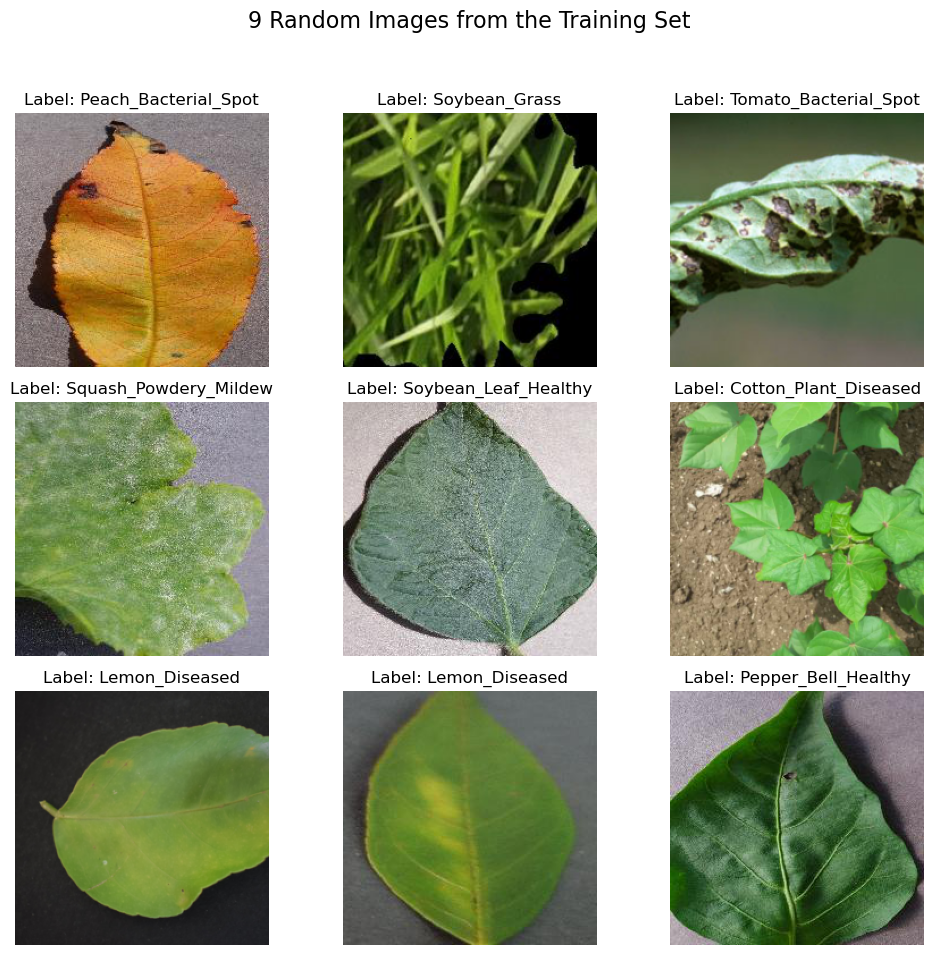

In [4]:
def get_transforms(normalize=False):
    """
    Create a transform pipeline with optional normalization
    
    Args:
        normalize (bool): Whether to include normalization for model input
    
    Returns:
        torchvision.transforms.Compose: The composed transforms
    """
    # Start with the basic transforms needed for all use cases
    transform_list = [
        transforms.Resize(256),  # Resize the smaller edge to 256
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels
        transforms.ToTensor(),  # Convert image to PyTorch Tensor (scales pixels to [0, 1])
    ]
    
    # Add normalization if requested (typically for model input)
    if normalize:
        transform_list.append(
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )
    
    return transforms.Compose(transform_list)

# For visualization (no normalization)
vis_transforms = get_transforms(normalize=False)

# For model input (with normalization)
model_transforms = get_transforms(normalize=True)

# Load the test dataset using the visualization transforms
test_dataset = datasets.ImageFolder(test_dir, vis_transforms)

# Get class names from the dataset folders
class_names = test_dataset.classes
print(f"Found classes: {class_names}")

# Get the total number of images in the training set
num_test_images = len(test_dataset)
print(f"Number of training images: {num_test_images}")

# Don't mind this little guy, it'll help us out later at the end of the notebook
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False
)  # Adjust batch_size as needed

# Select 9 random indices
random_indices = random.sample(range(num_test_images), 9)

# --- Display the images ---

plt.figure(figsize=(10, 10))  # Adjust figure size as needed
plt.suptitle(
    "9 Random Images from the Training Set", fontsize=16
)  # Add a title to the figure

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)

    # Get the image and label from the dataset using the random index
    image_tensor, label_index = test_dataset[idx]

    # Image tensors from ToTensor() are CxHxW and values are [0, 1].
    # Matplotlib expects HxWxC and values [0, 1] for floats or [0, 255] for integers.
    # We need to rearrange dimensions using permute.
    image_for_plot = image_tensor.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(image_for_plot)

    # Get the class name using the label index
    label_name = class_names[label_index]
    plt.title(f"Label: {label_name}")

    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent title overlap
plt.show()

### 4.1 Examine the Model: Baseline CNN

We will look at a sample CNN architecture (the same architecture used to train the baseline model) to see how it is set up. In this notebook we will *not* train the model as that would take a long time (about 10 minutes per epoch on a GPU). After we look at this and the VGG19 model, we'll compare the two using training runs that we've already done.

When you have time, the notebook [00.5_transfer_learning_helper.ipynb](00.5_transfer_learning_helper.ipynb) is included in this repository and you can train the model from scratch there!

In [5]:
# Define baseline model using PyTorch
class BaselineModel(nn.Module):
    def __init__(self, num_classes):
        super(BaselineModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 112 * 112, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Define the model
num_classes = 86

# Load the model
baseline_model = BaselineModel(num_classes)

# Display the model architecture
print(baseline_model)

BaselineModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=401408, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=86, bias=True)
  )
)


Overall, this model is a relatively simple CNN model that you might start with if you built a model from scratch. Again, rather than train this model in this notebook, we are loading in the result of training it. We have saved the trained weights, and are loading these in.

### 4.2 Examine the Model: VGG19

We will look at the VGG19 model architecture to see how it is set up. This model was a state of the art model in 2014, winning the ImageNet competion. You can check out the [Simonyan and Zisserman (2014) paper on the VGG models here](https://arxiv.org/abs/1409.1556).

In [7]:
# Load the base model VGG19 architecture from torchvision
vgg19 = models.vgg19(weights=None)  # Start with non-pretrained model (weights=None)

# Modify the final classifier layer to match your fine-tuned model (86 classes)
vgg19.classifier[6] = nn.Linear(4096, num_classes)

# Now load the weights for VGG19 that we fine-tuned
vgg19.load_state_dict(torch.load(vgg19_model_ft))

# Set the model to evaluation mode
vgg19.eval()

# Display the model architecture
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### 5. Compare the Models

Even if you're unfamiliar with the ins and outs of computer vision, it's easy to see from the prints of the architectures that VGG19 is a lot more complex than the simple CNN we've set up. Given that VGG19 is much larger, it would normally be the case that training it from random weights would take a lot longer. However, because it's pre-trained on ImageNet, we can *fine-tune* just the last few layers to get a model that is more accurate than the baseline CNN, and in comparable time!

One measure of model complexity is the number of parameters.

In [8]:
def count_parameters(model):
    '''Count the number of parameters in a model.'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print parameter numbers

print(f"The 'baseline_model' model has {count_parameters(baseline_model):,} parameters")
print(f"The 'vgg19' model has {count_parameters(vgg19):,} parameters")

The 'baseline_model' model has 51,392,342 parameters
The 'vgg19' model has 139,922,582 parameters


### 6. Evaluate the Models

Earlier in the notebook we downloaded trained models: 

1. The `baseline_model` was trained from scratch. It took approximately 50 minutes to train for 5 epochs.
1. The `vgg19` was fine-tuned from the VGG19 model starting from the weights learned in training on the ImageNet dataset. It took roughly the same amount of time (50 minutes for 5 epochs), even though it has nearly 3 times more parameters.

We will load these models and evaluate them on the test set to see how they perform.

In [12]:
# Allow loading of truncated images, since the dataset's images aren't all the same size!
ImageFile.LOAD_TRUNCATED_IMAGES = True

def pil_loader(path):
    """Custom image loader that handles truncated images"""
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluate a model on a dataset with progress bar
    
    Args:
        model: PyTorch model to evaluate
        data_loader: DataLoader containing the evaluation data
        criterion: Loss function
        device: Device to run evaluation on (cuda/cpu)
        
    Returns:
        tuple: (loss, accuracy) on the dataset
    """
    # Set model to evaluation mode and move to device
    model.eval()
    model.to(device)
    
    # Initialize variables to track metrics
    running_loss = 0.0
    running_corrects = 0
    total_samples = len(data_loader.dataset)
    
    # Iterate over the dataset with progress bar
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # Update loss
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    
    # Calculate final metrics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc


# Define the loss function
criterion = nn.CrossEntropyLoss()

# Load our trained Baseline CNN model
baseline_model.load_state_dict(torch.load(baseline_model_trained))

# Create a DataLoader with custom image loader to handle truncated images
test_dataset = datasets.ImageFolder(test_dir, model_transforms, loader=pil_loader)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=512, shuffle=False,
    num_workers=4, pin_memory=True
)

# Evaluate the baseline model
baseline_loss, baseline_acc = evaluate_model(baseline_model, test_loader, criterion, device)
print(f"Baseline Model: Loss: {baseline_loss:.4f}, Accuracy: {baseline_acc:.4f}")

# Evaluate the VGG19 model
vgg19_loss, vgg19_acc = evaluate_model(vgg19, test_loader, criterion, device)
print(f"VGG19 Model: Loss: {vgg19_loss:.4f}, Accuracy: {vgg19_acc:.4f}")

Evaluating: 100%|██████████| 36/36 [01:59<00:00,  3.32s/it]


Baseline Model: Loss: 3.7783, Accuracy: 0.1044


Evaluating: 100%|██████████| 36/36 [02:05<00:00,  3.50s/it]

VGG19 Model: Loss: 0.5265, Accuracy: 0.8375


### 7. Conclusion

We can see why the researchers behind AgriNet chose to use transfer learning to train their model. The VGG19 model, pre-trained on ImageNet, was able to achieve a higher accuracy than the CNN trained from scratch. This is a great example of how transfer learning can be used to improve the efficiency of training a model.

### Key Takeaways
- Fine-tuning is a powerful technique that can be used to improve the efficiency of training a model.
- Fine-tuning is especially useful when working with limited data.
- Pre-trained models can be fine-tuned on a new dataset to typically achieve better performance than training a model from scratch.